In [1]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense,Dropout
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing


plot_path = "plots/"






In [2]:

# Real server data

root_path = "Data/Ant_202007/"


cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

    
# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")
os.listdir(root_path)


if True:
    
    # calculate previous hour high low:
    # convert to seconds
    temp = df['time_stamp'] - min(df['time_stamp'])
    temp = temp.dt.total_seconds().astype(int)
    df["hours"] = temp//3600

    h_max = max(df["hours"])+1

    for n in range(len(names_array)):
        df[names_array[n]+"_open"] = df[names_array[n]]
        df[names_array[n]+"_close"] = df[names_array[n]]
        df[names_array[n]+"_max"] = df[names_array[n]]
        df[names_array[n]+"_min"] = df[names_array[n]]

    for j in range(1,h_max):
        mask_j = df["hours"]==j-1
        max_val = df[mask_j][names_array].max(axis=0).values
        min_val = df[mask_j][names_array].max(axis=0).values
        open_val = df[mask_j][names_array].values[0,:]
        close_val = df[mask_j][names_array].values[-1,:]
        mask_i = df["hours"]==j
        r = df[mask_i][names_array].shape[0]
        df.loc[mask_i,[r+"_open" for r in names_array]] = np.tile(open_val,(r,1))
        df.loc[mask_i,[r+"_close" for r in names_array]] = np.tile(close_val,(r,1))

        df.loc[mask_i,[r+"_max" for r in names_array]] = np.tile(max_val,(r,1))
        df.loc[mask_i,[r+"_min" for r in names_array]] = np.tile(min_val,(r,1))
    
    




In [3]:
# scale dot attention:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # Dimension of k
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    # calculate attention weight:
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# Multi-head Attention:
# This is what we use
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        
        # Always use Super to inheriatte and avoid extra code.
        assert d_model%num_heads==0
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        # sanity check:
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        # Q K W:
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    def split_heads(self, x, batch_size):
        # Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # https://www.tensorflow.org/api_docs/python/tf/transpose : perm
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        ## Can add mask here to do log-sparse attention
        
        return output, attention_weights
    
    
        
        
# check our Multi-head attention:
# D_model must be divided by num_head

n_d_model=32
temp_mha = MultiHeadAttention(d_model=n_d_model, num_heads=8)
y = tf.random.uniform((16, 60, n_d_model))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape
    



(TensorShape([16, 60, 32]), TensorShape([16, 8, 60, 60]))

In [4]:
# Transformer
# include encoder and decoder:
num_layers = 2
d_model=512
num_heads =8

dff = 1024

input_length = 180
output_length = 1


def point_wise_feed_forward_network(d_model, dff):
    # Two FC layers:
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])



class EncoderLayer(tf.keras.layers.Layer):
    # Here we use a 0.1 dropout rate as default
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2

class Transformer(tf.keras.models.Model):
    def __init__(self, num_layers, d_model, num_heads,input_length,output_length,dff,rate=0.1,training=False):
        super(Transformer, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.input_length = input_length
        self.output_length = output_length
        self.dff = dff
        self.rate = rate
        self.training = training
        
    def encoder_layer(self,x):
        # no mask for now
        mask = None
        training = self.training
        
        
        
        self.mha = MultiHeadAttention(self.d_model, self.num_heads)
        self.ffn = point_wise_feed_forward_network(self.d_model, self.dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(self.rate)
        self.dropout2 = tf.keras.layers.Dropout(self.rate)
        #print("check",x.shape)
        #print("1",x.shape)
        
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        #print("2",attn_output.shape)
        attn_output = self.dropout1(attn_output, training=training)
        
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        #print("3",out1.shape)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        out2 = self.layernorm2(out1 + ffn_output) 
        #print("4",out2.shape)
        return out2
        
        

    def encoder(self,x):
        training = self.training
        # simply encode x into d_model
        
        ## need to change: still need embedding here:
        
        
        x = Dense(d_model)(x)
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # no positional encoding for now
        
        x = Dropout(self.rate)(x, training=training)
        
        # encoder layer: based on mha:
        
        self.enc_layers = [self.encoder_layer for _ in range(num_layers)]
        #print(x.shape)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        
        #print(x.shape)
        return x
    
    def DecoderLayer(self,x,enc_output):
        training = self.training
        self.mha1 = MultiHeadAttention(self.d_model, self.num_heads)
        self.mha2 = MultiHeadAttention(self.d_model, self.num_heads)

        self.ffn = point_wise_feed_forward_network(self.d_model, self.dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(self.rate)
        self.dropout2 = tf.keras.layers.Dropout(self.rate)
        self.dropout3 = tf.keras.layers.Dropout(self.rate)
        
        # no mask for now
        look_ahead_mask = None
        padding_mask = None
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2
    
    
    def decoder(self,x,enc_output):
        training = self.training
        
        attention_weights = {}
        
        x = Dense(d_model)(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        x = Dropout(self.rate)(x,training=training)
        
        
        self.dec_layers = [self.DecoderLayer
                           for _ in range(self.num_layers)]
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    
    def call(self,inp,tar,training=False):
        self.training = training
        
        
        enc_output = self.encoder(inp)
        dec_output, attention_weights = self.decoder(tar, enc_output)
        
        self.final_layer = tf.keras.layers.Dense(self.output_length)
        dec_output = tf.keras.layers.Flatten()(dec_output)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        #print("check",final_output.shape,dec_output.shape)
        
        return final_output, attention_weights
        

        
        
        

In [5]:
model = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads,input_length=input_length,output_length=output_length,dff=dff)

In [6]:
temp_input = tf.random.uniform((64, 180), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 1), dtype=tf.int64, minval=0, maxval=200)

temp_input = tf.cast(temp_input,dtype=tf.float32)
temp_target = tf.cast(temp_target,dtype=tf.float32)

In [7]:
model.encoder(x=temp_input).shape

TensorShape([64, 64, 512])

In [8]:
output = model.encoder(x=temp_input)
output.shape

TensorShape([64, 64, 512])

In [9]:
output, _ = model.decoder(x=temp_input,enc_output=model.encoder(x=temp_input))
output.shape

TensorShape([64, 64, 512])

In [10]:
final_output, attention_weights = model.call(temp_input,temp_target,training=True)
final_output.shape

TensorShape([64, 1])

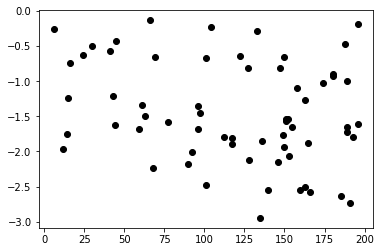

In [11]:
plt.plot(temp_target,final_output[:,0],"ko")

In [12]:
# check the model:
temp_input = tf.random.uniform((64, 180), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 1), dtype=tf.int64, minval=0, maxval=200)

temp_input = tf.cast(temp_input,dtype=tf.float32)
temp_target = tf.cast(temp_target,dtype=tf.float32)
model = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads,input_length=input_length,output_length=output_length,dff=dff,training=True)


fn_out, _ = model.call(temp_input,-temp_target,training=True)
fn_out.shape

TensorShape([64, 1])

Text(0.5, 0, 'Train Step')

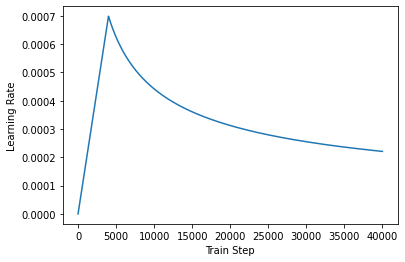

In [13]:
## Optimizor:

# Optimizor

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
# Learning rate curve:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [48]:
# loss and metric
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')




def loss_function(real, pred):
    # no mask:
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    #loss_ = loss_object(real, pred)

    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
    loss = tf.cast(tf.reduce_sum(real-pred),dtype=tf.float32)
  
    #return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
    return loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [17]:


# prepare data : 180 for 1
index_name=0
min_max_scaler = preprocessing.StandardScaler()

# min-max scaler
np_scaled = min_max_scaler.fit_transform(df[names_array])

#df_scaled = pd.DataFrame(np_scaled,columns=names_array)

df_scaled = pd.DataFrame(df[names_array],columns=names_array)
X = np.zeros((df_scaled.shape[0]-input_length,input_length,1),dtype=float)
y = df_scaled[names_array[index_name]][input_length:]

for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,0] = df_scaled[i:i+input_length][names_array[index_name]].values
    



Prepare data 0.00 percent
Prepare data 24.05 percent
Prepare data 48.10 percent
Prepare data 72.15 percent
Prepare data 96.20 percent


In [18]:
"""
    
# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

print("Finished preparing data")   

"""
# use tf built in function for train test split:


'\n    \n# split train test:\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)\n\nprint("Finished preparing data")   \n\n'

In [61]:
batch =8
temp_input = tf.random.uniform((batch, 180), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((batch, 1), dtype=tf.int64, minval=0, maxval=200)

temp_input = tf.cast(temp_input,dtype=tf.float32)
temp_target = tf.cast(temp_target,dtype=tf.float32)


model = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads,input_length=input_length,output_length=output_length,dff=dff,training=True)


train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)


def train_step(inp, tar):

    with tf.GradientTape() as tape:
        predictions, _ = model.call(inp,tar,training=True)
        loss = loss_function(tar, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    #temp = np.nansum(abs(np.array(predictions).ravel()-temp_target))
    #print(temp)
    train_loss(loss)
    train_accuracy(tar, predictions)
    return loss
    






In [ ]:

X = tf.cast(X,dtype=tf.float32)
y = tf.cast(y,dtype=tf.float32)
n_epoch = 10
# N//batch
loss_array = []
N = len(y)

for j in range(n_epoch):
    
    for i in range(N//batch):
        inp, tar=X[batch*i:min(batch*i+batch,N),:,0],y[batch*i:min(batch*i+batch,N)]
        tar = np.atleast_2d(tar).T
        temp = train_step(inp, tar)
        if i%200==0:
            print("Doing %d (%d) batch in epoch %d loss=%.2f"%(i,N//batch,j,temp))

        loss_array.append(temp)
        #train_step(temp_input,temp_target)
    

In [ ]:

def train_step(inp, tar):

    with tf.GradientTape() as tape:
        predictions, _ = model.call(inp,tar,training=True)
        loss = loss_function(tar, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    #temp = np.nansum(abs(np.array(predictions).ravel()-temp_target))
    #print(temp)
    train_loss(loss)
    train_accuracy(tar, predictions)
    return loss
    

train_step(inp,tar)

